In [96]:
import os
from pathlib import Path
os.chdir("/home/haok/MoE-Research")

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor


In [ ]:
def plot(specialization: torch.Tensor):
    sorted_vals, _ = specialization.sort(descending=True)
    x = range(len(sorted_vals))
    y = sorted_vals.numpy()

    sns.set(style="whitegrid", font_scale=1.0)
    plt.figure(figsize=(10, 3))
    sns.lineplot(x=x, y=y, linewidth=1.0)
    plt.xlabel("Token Index (sorted by specialization)")
    plt.ylabel("Response Fraction")
    plt.title("Expert Specialization")
    plt.tight_layout()
    plt.show()

def plot_specialization_difference(spec1: torch.Tensor, spec2: torch.Tensor, label1="Early", label2="Late"):
    diff = (spec2 - spec1).numpy()
    x = range(len(diff))

    sns.set(style="whitegrid", font_scale=1.0)
    plt.figure(figsize=(10, 3))
    sns.lineplot(x=x, y=diff)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.xlabel("Token Index")
    plt.ylabel(f"{label2} − {label1}")
    plt.title("Difference in Expert Specialization")
    plt.tight_layout()
    plt.show()

def plot_cumulative_specialization(spec: torch.Tensor):
    sorted_vals, _ = spec.sort(descending=True)
    cumulative = sorted_vals.cumsum(0).numpy()
    cumulative /= cumulative[-1]  # normalize to [0, 1]

    plt.figure(figsize=(6, 3))
    sns.lineplot(x=range(len(cumulative)), y=cumulative)
    plt.xlabel("Top-k Tokens")
    plt.ylabel("Cumulative Mass")
    plt.title("Cumulative Expert Specialization")
    plt.tight_layout()
    plt.show()


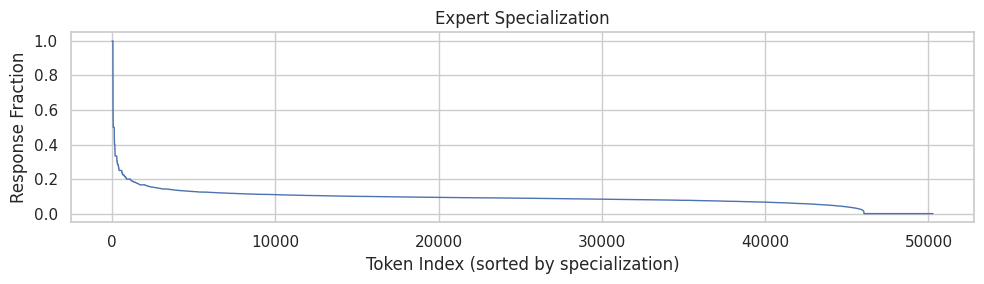

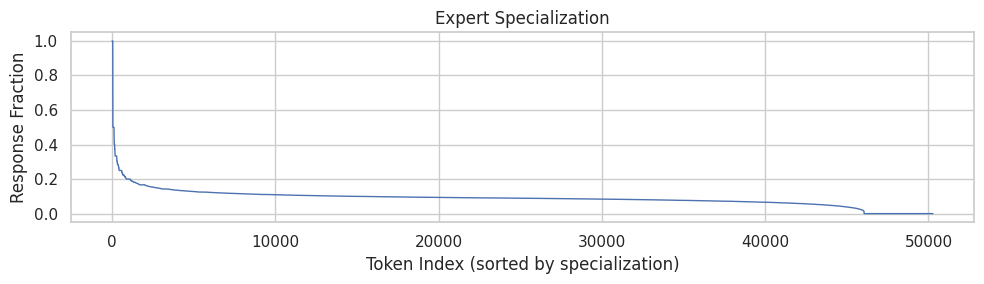

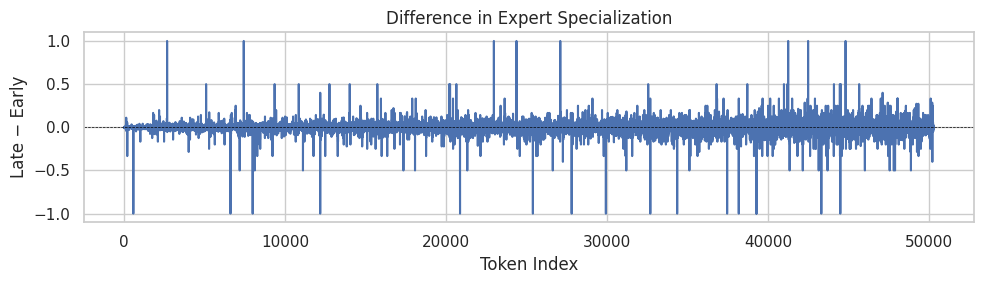

In [77]:
# spec1: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/1100/18-24.pt")
# spec2: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/11029/18-24.pt")

# spec1: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/1100/2-24.pt")
# spec2: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/11029/2-24.pt")

spec1: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/5500/18-24.pt")
spec2: Tensor = torch.load("results/expert-specialization/flame-moe-1.7b/11029/18-24.pt")

plot(spec1); plot(spec2)
plot_specialization_difference(spec1, spec2)


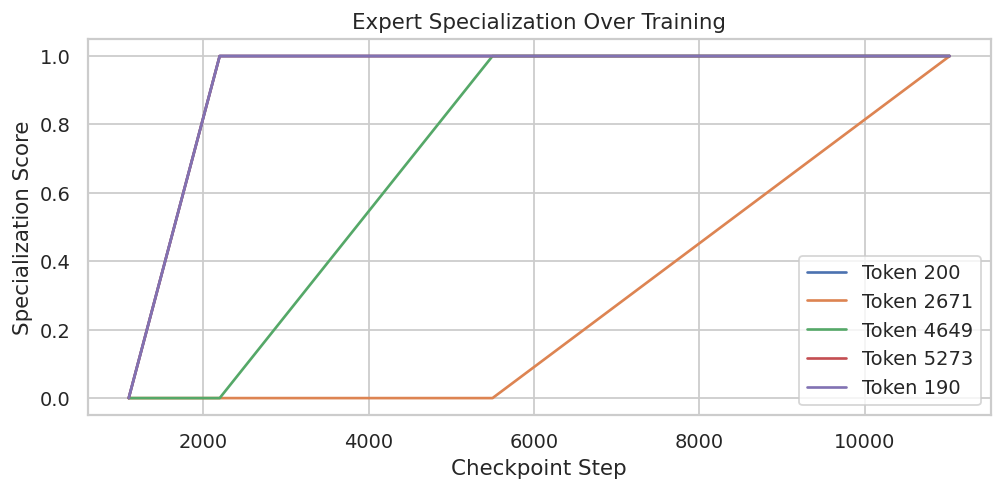

In [111]:
files = sorted(Path("results/expert-specialization/flame-moe-1.7b").glob("*/18-24.pt"), key=lambda p: int(p.parts[-2]))
steps = [int(p.parts[-2]) for p in files]
indices = torch.load(files[-1]).topk(5).indices

data = []
for file in files:
    spec = torch.load(file)
    data.append(spec[indices].tolist())

data = list(zip(*data))
plt.figure(figsize=(8, 4), dpi=128)
for i, scores in enumerate(data):
    plt.plot(steps, scores, label=f"Token {indices[i].item()}")

plt.xlabel("Checkpoint Step")
plt.ylabel("Specialization Score")
plt.title("Expert Specialization Over Training")
plt.legend()
plt.tight_layout()
plt.show()
